# 1

The suicide dataset consists of country, year, sex, age, suicides_no, population, suicides/100k pop, country-year, HDI for year, gdp_for_year, gdp_per_capita, and generation. This represents the number of suicides per year based on countries. This data set was compiled from four other datasets linked by time and place, and was built to find signals correlated to increased suicide rates among different cohorts globally, across the socio-economic spectrum

# 2

- country - country data came from
- year - year data was collected
- sex - binary values 'male' or 'female' can easily be used as a classification 0 or 1
- age, given as a range ex. '35-54 years'
- suicides_no
- population
- suicides/100k pop
- country-year
- HDI for year
- gdp_for_year ($)
- gdp_per_capita ($)
- generation


In [68]:
import pandas as pd
import numpy as np

# Loading data
df = pd.read_csv("../data/suicide.csv")
df.loc[df['HDI for year'].isna(), ['country', 'year']].drop_duplicates()   


,country,year
0,Albania,1987
12,Albania,1988
24,Albania,1989
36,Albania,1992
48,Albania,1993
...,...,...
27688,Uzbekistan,2001
27700,Uzbekistan,2002
27712,Uzbekistan,2003
27724,Uzbekistan,2004


In [69]:
# Creating our target column we are trying to predict the risk of suicide (high or low) by analyzing the information 
# from 'suicides/100k pop' column

df['suicide_risk'] = 'low'

df.loc[df['suicides/100k pop'] > df['suicides/100k pop'].mean(), 'suicide_risk'] = 'high'

df['suicide_risk'].value_counts()

low     19061
high     8759
Name: suicide_risk, dtype: int64

<AxesSubplot:>

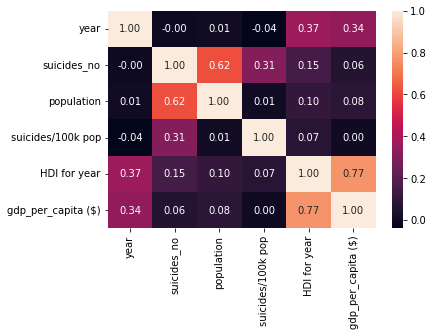

In [70]:
import seaborn as sns

sns.color_palette("rocket", as_cmap=True)
sns.heatmap(df.corr(), annot=True, fmt='.2f')

Text(0.5, 1.0, 'Suicides by Age and Gender (1985-2016)')

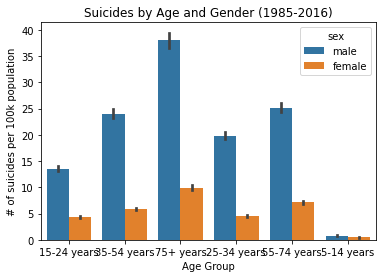

In [71]:
import matplotlib.pyplot as plt

sns.barplot(data=df, x='age', y='suicides/100k pop', hue='sex')
plt.xlabel('Age Group')
plt.ylabel('# of suicides per 100k population')
plt.title('Suicides by Age and Gender (1985-2016)')

In [72]:

# Train, Validation, and Test Sets

train_df = df.loc[df['year'] <= 2004]
validation_df = df.loc[(df['year'] >= 2005) & (df['year'] <= 2010)]
test_df = df.loc[df['year'] >= 2011]

print('Train DF Shape: ', train_df.shape)
print('Validation DF Shape: ', validation_df.shape)
print('Test DF Shape: ', test_df.shape)

input_cols = ['country', 'sex', 'age']
target_col = 'suicide_risk'

train_inputs = train_df.loc[:, input_cols]
train_target = train_df.loc[:, target_col]

validation_inputs = validation_df.loc[:, input_cols]
validation_target = validation_df.loc[:, target_col]

test_inputs = test_df.loc[:, input_cols]
test_target = test_df.loc[:, target_col]

numerical_columns = list(train_inputs.select_dtypes(include=np.number).columns)
categorical_columns = list(train_inputs.select_dtypes(include=['object']).columns)

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore').fit(df[categorical_columns])

encoded_columns = list(encoder.get_feature_names(categorical_columns))

train_inputs[encoded_columns] = encoder.transform(train_inputs.loc[:, categorical_columns]).toarray()
validation_inputs[encoded_columns] = encoder.transform(validation_inputs.loc[:, categorical_columns]).toarray()
test_inputs[encoded_columns] = encoder.transform(test_inputs.loc[:, categorical_columns]).toarray()

# Decision Tree Inputs
X_train = train_inputs[numerical_columns + encoded_columns]
X_validate = validation_inputs[numerical_columns + encoded_columns]
X_test = test_inputs[numerical_columns + encoded_columns]

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, train_target)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, train_target)

n_train_pred = neigh.predict(X_train)
accuracy_score(train_target, n_train_pred)

n_validate_pred = neigh.predict(X_validate)
accuracy_score(validation_target, n_validate_pred) # About 87-88% accurate

train_prediction = tree.predict(X_train)
accuracy_score(train_target, train_prediction)

validation_prediction = tree.predict(X_validate)
accuracy_score(validation_target, validation_prediction) # About 88% accurate

validation_target.value_counts() / len(validation_target)

from sklearn.tree import plot_tree
plt.figure(figsize=(80,20))
plot_tree(tree, feature_names=X_train.columns, max_depth=2, filled=True)



Train DF Shape:  (16812, 13)
Validation DF Shape:  (6204, 13)
Test DF Shape:  (4804, 13)


/Users/jacob/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/t4/ybx0qpc17lgbs28t98mp2wk40000gn/T/ipykernel_72528/3364698623.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_columns] = encoder.transform(train_inputs.loc[:, categorical_columns]).toarray()
/var/folders/t4/ybx0qpc17lgbs28t98mp2wk40000gn/T/ipykernel_72528/3364698623.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

0.8778207607994842

Text(0.5, 1.0, 'Feature Importance in Decision Tree')

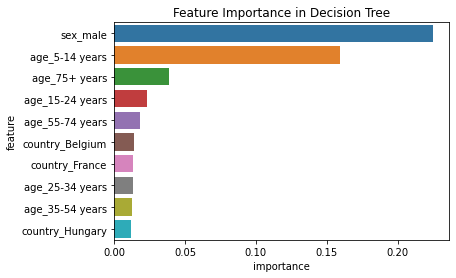

In [73]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': tree.feature_importances_
}).sort_values(by='importance', ascending=False)

sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Feature Importance in Decision Tree')